In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400,900),)
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 2s (126 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 147475 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxx

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

import numpy as np

import random
import math

import collections
from collections import namedtuple

In [0]:
step = namedtuple("step", ("state", "action", "next_state", "reward", "done"))

class Replay:
    def __init__(self, size):
        self.memory = collections.deque(maxlen = size)
        
    def push(self, data):
        self.memory.append(data)
        
    def prepare(self, env):
        pass
        
    def sample(self, size):
        if len(self.memory) >= size:
            return random.sample(self.memory, size)

In [0]:
import numpy as np
import math

class NoiseMaker():
    def __init__(self, noise_type, size, param = None):
        self.noise_type = noise_type
        self.saved_states = np.zeros((size,), dtype=np.float32)
        self.size = size
        self.count = 0
        self.param = param
        
        if self.param is None:
            self.param = {
                "start": 0.9,
                "end": 0.05,
                "decay": 20000
            }
        if noise_type == "ou" and param is None:
            self.param["ou_mu"] = 0.0,
            self.param["ou_th"] = 0.15,
            self.param["ou_sig"] = 0.2
        
    def get_max_action(self, action_v:np.ndarray):
        max_indice = (action_v==action_v.max()).nonzero()[0]
        return np.random.choice(max_indice)
    
    def get_noise(self, noise_type = None):
        noise_type = noise_type if noise_type is not None else self.noise_type
        
        eps = self.param["end"] + (self.param["start"] - self.param["end"]) \
            * math.exp(-1 * self.count / self.param["decay"])
        
        if noise_type == "ou":
            self.saved_states += self.param["ou_th"] * (self.param["ou_mu"] - self.saved_states) \
                                + self.param["ou_sig"] * np.random.normal(size = self.size)
            noise_v = self.saved_states
        elif noise_type == "simple":
            noise_v = np.random.normal(size=self.size)
        
        self.count += 1
        return noise_v * eps

In [0]:
class Actor(nn.Module):
    def __init__(self, state_n, action_n, hidden = 512):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_n, hidden),
            nn.ReLU(),
            nn.Linear(hidden, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), action_n),
            nn.Tanh()
        )
        
    def forward(self,x):
        return self.net(x)
    
class Critic(nn.Module):
    def __init__(self, state_n, action_n, hidden =512):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_n, hidden),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(hidden+action_n, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), 1)
        )
        
    def forward(self, state, act):
        temp = self.net(state)
        return self.out(torch.cat([temp, act], dim=1))

In [6]:
EPOCH = 5000
GAME_NAME = "MountainCar-v0"

env = gym.make(GAME_NAME)
obs_n = env.observation_space.shape[0]
act_n = env.action_space.n

LR_ACT = 0.0008
LR_CRT = 0.004
TAU = 0.0008
GAMMA = 0.99

actor = Actor(obs_n, act_n).cuda()
actor_optim = optim.Adam(actor.parameters(), lr = LR_ACT)
actor_tgt = Actor(obs_n, act_n).cuda()
actor_tgt.load_state_dict(actor.state_dict())

critic = Critic(obs_n, act_n).cuda()
critic_optim = optim.Adam(critic.parameters(), lr = LR_CRT)
critic_tgt = Critic(obs_n, act_n).cuda()
critic_tgt.load_state_dict(critic.state_dict())

MAX_MEMORY = 100000
MEM_INIT = 2000
BATCH = 512
storage = Replay(MAX_MEMORY)
noise = NoiseMaker("ou", act_n)

VIDEO = 100

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
frame = []

for epoch in range(EPOCH):
    obs = env.reset()
    if epoch%VIDEO == 0:
        frame.append(env.render("rgb_array"))
    
    count = 0
    act_dis = [0,0,0]
    while True:
        with torch.no_grad():
            act_v = actor(torch.FloatTensor(obs).cuda()).cpu().numpy()
            act_v += noise.get_noise("ou")
            act = act_v.argmax().item()
            act_dis[act] += 1
            
        next_obs, rew, done, _ = env.step(act)
        if epoch%VIDEO == 0:
            frame.append(env.render("rgb_array"))
        rew = next_obs[0]
        count += 1
        
        storage.push(step(obs, act_v, next_obs, rew, done))
        obs = next_obs
        
        sample = storage.sample(BATCH)
        if sample:
            sample = step(*zip(*sample))
            
            states = torch.FloatTensor(sample.state).cuda()
            actions = torch.FloatTensor(sample.action).cuda()
            next_states = torch.FloatTensor(sample.next_state).cuda()
            rewards = torch.FloatTensor(sample.reward).unsqueeze(-1).cuda()
            dones = torch.BoolTensor(sample.done).unsqueeze(-1).cuda()
            
            # critic learning
            critic_optim.zero_grad()
            q_pred = critic(states, actions)
            
            next_action_v = actor_tgt(next_states)
            q_next = critic_tgt(next_states, next_action_v)
            q_next[dones] = 0
            q_target = rewards + GAMMA * q_next
            
            critic_loss = F.mse_loss(q_pred, q_target.detach())
            critic_loss.backward()
            critic_optim.step()
            
            # actor learning
            actor_optim.zero_grad()
            actor_loss = -critic(states, actor(states))
            actor_loss = actor_loss.mean()
            actor_loss.backward()
            actor_optim.step()
            
            # tgt soft update
            for tgt, real  in zip(actor_tgt.parameters(), actor.parameters()):
                tgt.data.copy_(TAU*real.data + (1-TAU)*tgt.data)
                
            for tgt, real  in zip(critic_tgt.parameters(),critic.parameters()):
                tgt.data.copy_(TAU*real.data + (1-TAU)*tgt.data)
            
        if done:
            break
    print("epoch %d count %d"%(epoch, count), act_dis)
    
env.close()

epoch 0 count 200 [63, 74, 63]
epoch 1 count 200 [35, 86, 79]
epoch 2 count 200 [64, 97, 39]
epoch 3 count 200 [50, 69, 81]
epoch 4 count 200 [79, 39, 82]
epoch 5 count 200 [74, 62, 64]
epoch 6 count 200 [5, 24, 171]
epoch 7 count 200 [0, 19, 181]
epoch 8 count 200 [0, 114, 86]
epoch 9 count 200 [0, 72, 128]
epoch 10 count 200 [2, 74, 124]
epoch 11 count 200 [43, 0, 157]
epoch 12 count 200 [39, 0, 161]
epoch 13 count 200 [1, 91, 108]
epoch 14 count 200 [7, 91, 102]
epoch 15 count 200 [12, 84, 104]
epoch 16 count 200 [0, 134, 66]
epoch 17 count 200 [0, 200, 0]
epoch 18 count 200 [0, 200, 0]
epoch 19 count 200 [0, 200, 0]
epoch 20 count 200 [0, 13, 187]
epoch 21 count 200 [0, 0, 200]
epoch 22 count 200 [0, 0, 200]
epoch 23 count 200 [0, 0, 200]
epoch 24 count 200 [0, 0, 200]
epoch 25 count 200 [0, 0, 200]
epoch 26 count 200 [0, 0, 200]
epoch 27 count 200 [0, 0, 200]
epoch 28 count 200 [0, 0, 200]
epoch 29 count 200 [0, 0, 200]
epoch 30 count 200 [0, 0, 200]
epoch 31 count 200 [0, 0, 200]

KeyboardInterrupt: ignored

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11428 sha256=30c5d83452f22d73c98bc56be44965115d198b735a57f7f0d021692f3829ba12
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation


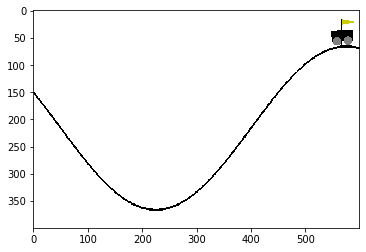

In [9]:
!pip install JSAnimation
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
from IPython.display import HTML
import matplotlib.pyplot as plt

# Imports specifically so we can render outputs in Colab.
def display_frames_as_gif(frame, intv=30):
    """Displays a list of frames as a gif, with controls."""
    fig = plt.figure()
    patch = plt.imshow(frame[0].astype(int))
    def animate(i):
        patch.set_data(frame[i].astype(int))
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frame), interval=intv, blit=False
    )
    #display(display_animation(anim, default_mode='loop'))
    # Set up formatting for the movie files
    display(HTML(data=anim.to_html5_video()))
    #FFwriter = animation.FFMpegWriter()
    #anim.save('basic_animation.mp4', writer = FFwriter)
    #show_video()
# display 

display_frames_as_gif(frame)